In [2]:
import argparse
import logging
import math
import os
import random
import shutil
from pathlib import Path

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset, load_from_disk
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available


In [9]:
def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")
    

tokenizer = AutoTokenizer.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    subfolder="tokenizer",
    revision=None,
    use_fast=False,
)

# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path( "stabilityai/stable-diffusion-2-1-base", None)
text_encoder = text_encoder_cls.from_pretrained(
         "stabilityai/stable-diffusion-2-1-base", subfolder="text_encoder", revision=None, variant=None
    )
# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained( "stabilityai/stable-diffusion-2-1-base", subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
     "stabilityai/stable-diffusion-2-1-base", subfolder="text_encoder", revision=None, variant=None
)
vae = AutoencoderKL.from_pretrained(
     "stabilityai/stable-diffusion-2-1-base", subfolder="vae", revision=None, variant=None
)
unet = UNet2DConditionModel.from_pretrained(
   "stabilityai/stable-diffusion-2-1-base", subfolder="unet", revision=None, variant=None
)
   
controlnet = ControlNetModel.from_pretrained("../../controlnet_landsat")
if is_xformers_available():
    import xformers

    xformers_version = version.parse(xformers.__version__)
    if xformers_version == version.parse("0.0.16"):
        print(
            "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
        )
    unet.enable_xformers_memory_efficient_attention()
    controlnet.enable_xformers_memory_efficient_attention()
pipeline = StableDiffusionControlNetPipeline(vae, text_encoder, tokenizer, unet, controlnet, noise_scheduler, safety_checker=None, feature_extractor=None).to("cuda")
pipeline

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.24.0",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [10]:
test_dataset = load_from_disk("../../data/landsat_large/test")

In [17]:
generator = torch.Generator(device='cuda').manual_seed(0)

save_dir = os.path.join("..","..","results", "granular")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for i,data in enumerate(test_dataset):
    input = data["input"]
    caption = data["captions"]
    # Run the pipeline
    with torch.autocast("cuda"):
        image = pipeline(
                        caption, input, num_inference_steps=20, generator=generator
                    ).images[0]
    # Save the image
    image.save(os.path.join(save_dir, str(i) + ".jpg"))
    if i == 2:
        break


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


In [16]:
test_dataset[0]

{'input': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'target': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'captions': 'A satellite image of the earth. The weather is clear.',
 'binary_captions': 'A satellite image of the earth. The weather is clear and sunny.',
 'cloud_segments': 0,
 'snow_segments': 0,
 'cloud_segments_binary': 0,
 'snow_segments_binary': 0}

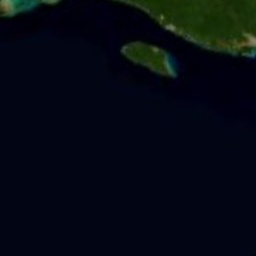

In [31]:
first_image

In [30]:
first_image, 

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'A satellite image of the earth. The weather is clear.')